/tmp/ipykernel_15113/3411465985.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(extracted_files))


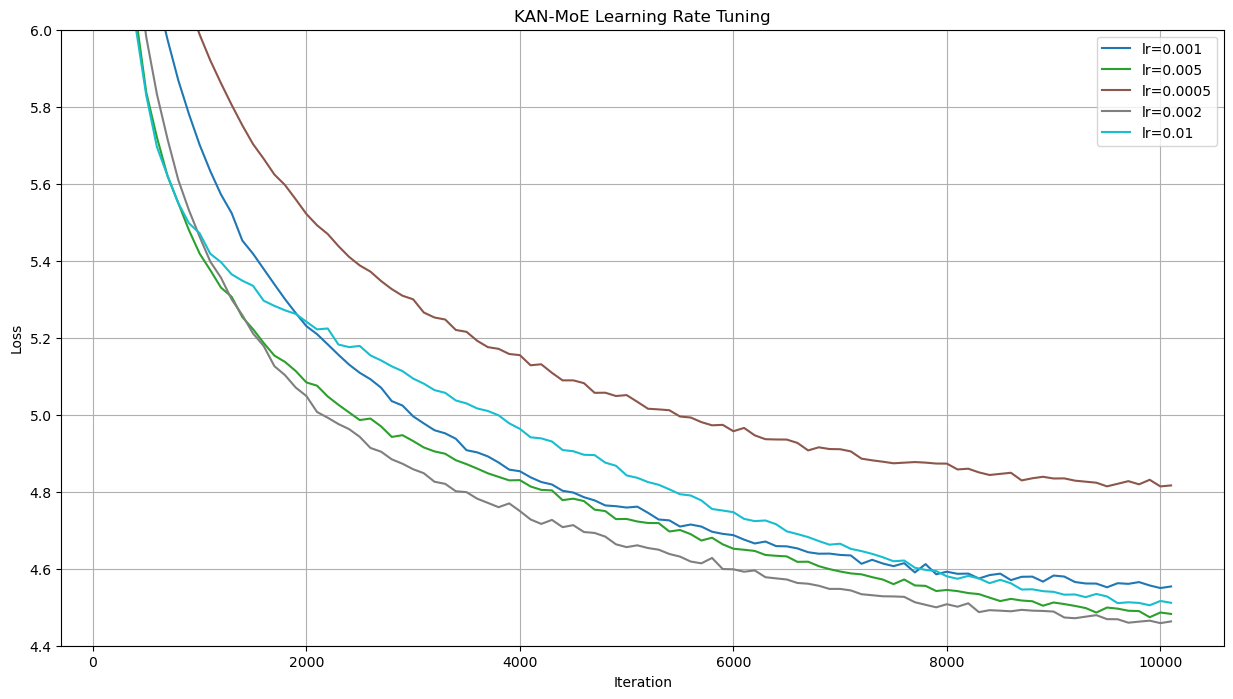

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import zipfile

# Path to the downloaded zip file
folder = 'kanmoe_lr_grid'
extract_to_path = '/home/janek/Downloads/' + folder

# List the files in the extracted directory
extracted_files = [file for file in os.listdir(extract_to_path) if file.endswith('.csv')]

# Create a plot
plt.figure(figsize=(15, 8))

# Define a list of colors
colors = plt.cm.get_cmap('tab10', len(extracted_files))

# Load each CSV file and plot it on the same axis
for i, file in enumerate(extracted_files):
    df = pd.read_csv(os.path.join(extract_to_path, file))
    df.columns = ['Iteration', 'Timestamp', 'Loss']
    df.sort_values(by='Iteration', inplace=True)
    
    # Plot the data
    plt.plot(df['Iteration'], df['Loss'], linestyle='-', color=colors(i), label=file[:-4])

# Add labels and title
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('KAN-MoE Learning Rate Tuning')
plt.legend()
plt.grid(True)

plt.ylim([4.4, 6.0])  # Adjust the range as needed

plt.savefig(f'/home/janek/Documents/kan_charts/{folder}.pdf', format='pdf')

# Show plot
plt.show()
